In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress tracking

class TrajectoryDataset(Dataset):
    def __init__(self, dataframe, window_length=100):
        # Transform the data using a sliding window
        sliced_df = self.custom_transformation(dataframe.to_numpy(), window_length)
        self.data = torch.tensor(sliced_df, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

    def custom_transformation(self, dataframe_array, window_length):
        # Stride view for efficient sliding window transformation
        window_length += 1  # Include target column
        sliced_data = np.lib.stride_tricks.sliding_window_view(dataframe_array, window_shape=(window_length,), axis=1)
        sliced_data = sliced_data.reshape(-1, window_length)  # Flatten for output
        return sliced_data

# Model definition
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.2)

        # Fully connected layers
        self.fc1_input_size = self.compute_fc_input_size(input_size)  # Moved calculation outside `__init__`
        self.fc1 = nn.Linear(self.fc1_input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def compute_fc_input_size(self, input_size):
        # Helper function to calculate the flattened size after conv layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_size)  # 1 batch, 1 channel, sequence length
            output = self.forward_conv_layers(dummy_input)
            return output.view(-1).size(0)

    def forward_conv_layers(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)

        return x

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.forward_conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten before fully connected layers
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # Final output layer

## Training loop

In [ ]:
import os

# Get the relative path of a file in the current working directory
train_path = os.path.join('train.csv')
val_path = os.path.join('val.csv')
test_path = os.path.join('test.csv')

train_df = pd.read_csv(train_path, header = 0).drop('ids', axis=1)
val_df = pd.read_csv(val_path, header = 0).drop('ids', axis=1)
test_df = pd.read_csv(test_path, header = 0).drop('ids', axis=1)


In [ ]:
# Check if MPS is available and set the device accordingly
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device("cuda")

window_length = 100  # Example window length
dataset = TrajectoryDataset(dataframe=train_df, window_length=window_length)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model hyperparameters
input_size = window_length  # Window length minus 1 (since the last column is the target)
hidden_size = 64
output_size = 1  # Single output for time series forecast (next value)
learning_rate = 0.001
num_epochs = 1

# Instantiate the model, loss function, and optimizer
model = Net(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with tqdm for progress tracking
for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
    model.train()
    running_loss = 0.0
    # Use tqdm to track batch progress within each epoch
    for batch_idx, data in tqdm(enumerate(dataloader), desc=f"Epoch {epoch + 1}", unit="batch", leave=False):
        # Separate inputs and targets
        inputs = data[:, :-1].to(device)  # All except last column
        targets = data[:, -1].to(device)  # Last column is the target (next value)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss per epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}')

Streaming output truncated to the last 5000 lines.
Epoch 1: 168233batch [26:31, 108.88batch/s]
Epoch 1: 168245batch [26:31, 109.46batch/s]
Epoch 1: 168257batch [26:31, 110.01batch/s]
Epoch 1: 168269batch [26:31, 111.02batch/s]
Epoch 1: 168281batch [26:31, 110.16batch/s]
Epoch 1: 168293batch [26:32, 111.10batch/s]
Epoch 1: 168305batch [26:32, 110.90batch/s]
Epoch 1: 168317batch [26:32, 110.87batch/s]
Epoch 1: 168329batch [26:32, 108.96batch/s]
Epoch 1: 168340batch [26:32, 109.11batch/s]
Epoch 1: 168352batch [26:32, 110.49batch/s]
Epoch 1: 168364batch [26:32, 108.08batch/s]
Epoch 1: 168375batch [26:32, 106.22batch/s]
Epoch 1: 168386batch [26:32, 105.17batch/s]
Epoch 1: 168398batch [26:33, 107.25batch/s]
Epoch 1: 168409batch [26:33, 107.60batch/s]
Epoch 1: 168421batch [26:33, 108.79batch/s]
Epoch 1: 168432batch [26:33, 108.10batch/s]
Epoch 1: 168443batch [26:33, 108.59batch/s]
Epoch 1: 168454batch [26:33, 107.67batch/s]
Epoch 1: 168465batch [26:33, 106.31batch/s]
Epoch 1: 168476batch [26:

Epoch [1/1], Loss: 0.0021


## Evaluation Loop

In [ ]:
from torch.nn import MSELoss


train_set = torch.tensor(train_df.values[:,:].astype(np.float32), dtype=torch.float32)
val_set = torch.tensor(val_df.values[:,:].astype(np.float32), dtype=torch.float32)
test_set = torch.tensor(val_df.values[:,:].astype(np.float32), dtype=torch.float32)

points_to_predict = val_set.shape[1]

# Autoregressive prediction function
def autoregressive_predict(model, input_maxtrix, prediction_length=points_to_predict):
    """
    Perform autoregressive prediction using the learned model.

    Args:
    - model: The trained PyTorch model.
    - input_maxtrix: A matrix of initial time steps (e.g., shape (963, window_length)).
    - prediction_length: The length of the future trajectory to predict.

    Returns:
    - output_matrix: A tensor of the predicted future trajectory of the same length as `prediction_length`.
    """
    model.eval()  # Set model to evaluation mode
    output_matrix = torch.empty(input_maxtrix.shape[0],0)
    current_input = input_maxtrix

    with torch.no_grad():  # No need to calculate gradients for prediction
        for idx in range(prediction_length):
            # Predict the next time step
            next_pred = model(current_input)

            # Concatenating the new column along dimension 1 (columns)
            output_matrix = torch.cat((output_matrix, next_pred), dim=1)

            # Use the predicted value as part of the next input
            current_input = torch.cat((current_input[:, 1:],next_pred),dim=1)

    return output_matrix


initial_input = train_set[:, -window_length:]  #use the last window of training set as initial input
full_trajectories = autoregressive_predict(model, initial_input)


# Calculate MSE between predicted trajectories and actual validation trajectories using torch
mse_loss = MSELoss()

# Compute MSE
mse = mse_loss(full_trajectories, val_set)

# Print MSE
print(f'Autoregressive Validation MSE (using torch): {mse.item():.4f}')

Autoregressive Validation MSE (using torch): 0.0020


## Plot it out to see what is like

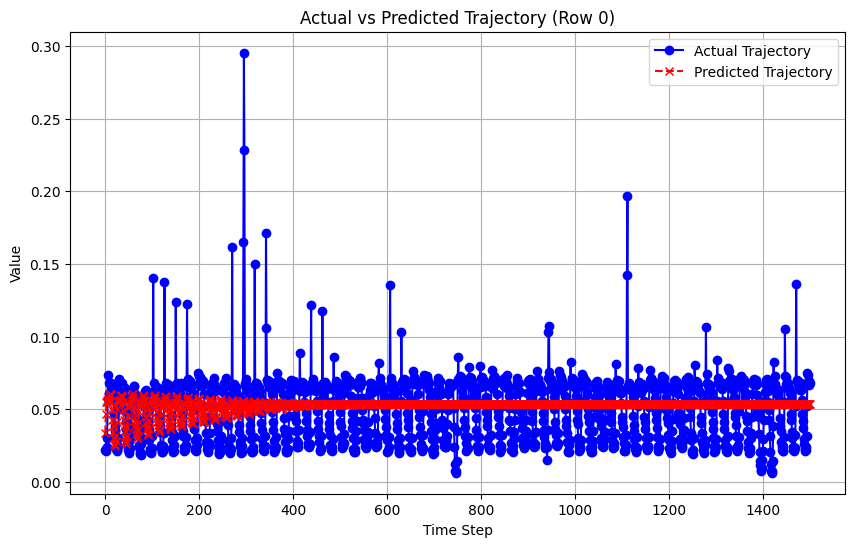

In [ ]:
# Perform autoregressive predictions for one row in the validation set
# We can pick a specific row (e.g., row 0) to visualize
row_idx = 0  # You can change this to visualize predictions for different rows
initial_input = val_set[row_idx, :window_length].unsqueeze(0)

# Predict future trajectory of length 100
predicted_trajectory = autoregressive_predict(model, initial_input)

# Get the actual trajectory for comparison
actual_trajectory = val_set[row_idx].numpy()

# Plot the actual vs predicted trajectory
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_trajectory)), actual_trajectory, label="Actual Trajectory", color='blue', marker='o')
plt.plot(range(len(actual_trajectory)), predicted_trajectory.squeeze().numpy(), label="Predicted Trajectory", color='red', linestyle='--', marker='x')
plt.title(f"Actual vs Predicted Trajectory (Row {row_idx})")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()